In [1]:
# =========================
# Setup y Configuración
# =========================
import numpy as np
import pandas as pd
from typing import List, Dict

import os
from dataclasses import dataclass
from typing import Tuple, List

from sqlalchemy import create_engine

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# --- Parámetros principales ---
TARGET_COL = "packets"        
PREDICTION_MODE = "next_step"  # "next_step" (pronóstico paso siguiente) o "final_total" (tamaño final)
PREFIX_LEN = 3                 # Para "final_total": cuántas filas iniciales por flujo usar
N_SPLITS = 5
RANDOM_STATE = 42

# Identidad de flujo (ajusta si usas otro identificador)
FLOW_KEYS: List[str] = ["src_ip", "dst_ip", "src_port", "dst_port", "protocol"]

# Columnas binarias (flags TCP)
FLAG_COLS = ["fin","syn","rst","psh","ack","urg"]

# Nota técnica: XGBoost es ampliamente usado para tareas de regresión en networking
# por su eficiencia y capacidad de manejar relaciones no lineales complejas.


In [17]:
# =========================
# Carga de Datos
# =========================
# Reemplaza esta celda con tu origen real:
#   - SQL: df = pd.read_sql("SELECT * FROM flow_metrics_logs ORDER BY ts ASC", engine)
#   - CSV: df = pd.read_csv("data/flow_metrics_logs.csv")

@dataclass
class DBConfig:
    host: str = os.getenv("DB_HOST")
    port: str = os.getenv("DB_PORT")
    db:   str = os.getenv("DB_NAME")
    user: str = os.getenv("DB_USER")
    pwd:  str = os.getenv("DB_PASSWORD")
    table: str = os.getenv("DATA_TABLE", "flow_metrics_logs")  

def make_engine(cfg: DBConfig):
    url = f"postgresql+psycopg2://{cfg.user}:{cfg.pwd}@{cfg.host}:{cfg.port}/{cfg.db}"
    return create_engine(url)

cfg = DBConfig()
engine = make_engine(cfg)
engine

Q = f"""
SELECT
  ts, pid, src_ip, dst_ip, src_port, dst_port, protocol,
  flow_let, last_timestamp_ns, delta_ns, packets, bytes, 
  fin, syn, rst, psh, ack, urg ,throughput,
  loss_est_pkts, dup_acks_est, ce
FROM flow_metrics_logs
ORDER BY ts ASC
"""

df = pd.read_sql(Q, engine)
df.head()


,ts,pid,src_ip,dst_ip,src_port,dst_port,protocol,flow_let,last_timestamp_ns,delta_ns,...,fin,syn,rst,psh,ack,urg,throughput,loss_est_pkts,dup_acks_est,ce
0,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,34907,6,0,9923236222479237,94780115,...,0,0,0,2,5,0,0.0,0,0,0
1,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,43197,6,0,9923236258989017,60017336,...,0,0,0,32,718,0,0.0,0,0,192
2,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,35029,6,0,9923236315611412,3975821,...,0,0,0,1,17,0,0.0,0,0,17
3,2025-10-05 22:02:09+00:00,-1,10.0.0.1,10.0.0.2,5201,47445,6,0,9923236315715892,4479791,...,0,0,0,0,0,0,0.0,0,0,0
4,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,60009,6,0,9923236304530159,16250864,...,0,0,0,6,178,0,0.0,0,0,148


In [3]:
# =========================
# Limpieza de Tipos y Valores
# =========================
numeric_like = [
    "delta_ns", "bytes", "throughput", "loss_est_pkts",
    "dup_acks_est", "last_timestamp_ns", TARGET_COL
]

for c in numeric_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

for c in FLAG_COLS:
    if c in df.columns:
        df[c] = df[c].fillna(0).astype(int)

df = df.dropna(subset=["ts"])  # asegurar timestamp
df.head()


,ts,pid,src_ip,dst_ip,src_port,dst_port,protocol,flow_let,last_timestamp_ns,delta_ns,packets,bytes,fin,syn,rst,psh,ack,urg,throughput,dup_acks_est
0,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,34907,6,0,9923236222479237,94780115,8,678,0,0,0,2,5,0,0.0,0
1,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,43197,6,0,9923236258989017,60017336,719,1054757,0,0,0,32,718,0,0.0,0
2,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,35029,6,0,9923236315611412,3975821,18,825825,0,0,0,1,17,0,0.0,0
3,2025-10-05 22:02:09+00:00,-1,10.0.0.1,10.0.0.2,5201,47445,6,0,9923236315715892,4479791,1,927749,0,0,0,0,0,0,0.0,0
4,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,60009,6,0,9923236304530159,16250864,208,588031,0,0,0,6,178,0,0.0,0


In [4]:
# =========================
# Funciones: Objetivo y Utilidades
# =========================
def build_next_step_target(_df: pd.DataFrame, group_keys: List[str], target: str) -> pd.DataFrame:
    g = _df.groupby(group_keys, sort=False)
    out = _df.copy()
    out["y"] = g[target].shift(-1)            # valor acumulado en el próximo registro del flujo
    out["lag_"+target] = g[target].shift(1)   # lag como feature opcional
    # eliminar el último punto de cada flujo (no tiene y)
    last_mask = g.cumcount(ascending=True) == (g[target].transform("size") - 1)
    out = out[~last_mask].copy()
    return out

def build_final_total_target(_df: pd.DataFrame, group_keys: List[str], target: str, prefix_len: int) -> pd.DataFrame:
    g = _df.groupby(group_keys, sort=False)
    out = _df.copy()
    out["y"] = g[target].transform("last")    # total acumulado final del flujo
    out["rank_in_flow"] = g.cumcount() + 1
    out = out[out["rank_in_flow"] <= prefix_len].copy()
    return out

def safe_rate(numer: pd.Series, denom_ns: pd.Series) -> pd.Series:
    secs = denom_ns.astype("float64") / 1e9
    secs = secs.replace(0, np.nan)
    return numer / secs


In [5]:
# =========================
# Construcción del Dataset de Trabajo
# =========================
if PREDICTION_MODE == "next_step":
    print(f'Total de muestras: {len(df)}')	
    work_df = build_next_step_target(df, FLOW_KEYS, TARGET_COL)
    print(f"Total muestras después de build_next_step_target: {len(work_df)}")
    print(work_df.head())
elif PREDICTION_MODE == "final_total":
    work_df = build_final_total_target(df, FLOW_KEYS, TARGET_COL, PREFIX_LEN)
else:
    raise ValueError("PREDICTION_MODE debe ser 'next_step' o 'final_total'.")

# Derivadas por flujo: difs y tasas
g = work_df.groupby(FLOW_KEYS, sort=False)
for col in ["packets", "bytes", "last_timestamp_ns"]:
    if col in work_df.columns:
        work_df["d_"+col] = g[col].diff().fillna(0)

if {"d_packets","delta_ns"}.issubset(work_df.columns):
    work_df["pps"] = safe_rate(work_df["d_packets"], work_df["delta_ns"]).fillna(0)
if {"d_bytes","delta_ns"}.issubset(work_df.columns):
    work_df["bps"] = safe_rate(work_df["d_bytes"], work_df["delta_ns"]).fillna(0)

work_df = work_df.dropna(subset=["y"]).reset_index(drop=True)
work_df.head()


Total de muestras: 372909
Total muestras después de build_next_step_target: 371394
                         ts     pid    src_ip    dst_ip  src_port  dst_port  \
0 2025-10-05 22:02:09+00:00  874207  10.0.0.1  10.0.0.2      5201     34907   
1 2025-10-05 22:02:09+00:00  874207  10.0.0.1  10.0.0.2      5201     43197   
2 2025-10-05 22:02:09+00:00  874207  10.0.0.1  10.0.0.2      5201     35029   
3 2025-10-05 22:02:09+00:00      -1  10.0.0.1  10.0.0.2      5201     47445   
4 2025-10-05 22:02:09+00:00  874207  10.0.0.1  10.0.0.2      5201     60009   

   protocol  flow_let  last_timestamp_ns  delta_ns  ...  fin  syn  rst  psh  \
0         6         0   9923236222479237  94780115  ...    0    0    0    2   
1         6         0   9923236258989017  60017336  ...    0    0    0   32   
2         6         0   9923236315611412   3975821  ...    0    0    0    1   
3         6         0   9923236315715892   4479791  ...    0    0    0    0   
4         6         0   9923236304530159  16250

,ts,pid,src_ip,dst_ip,src_port,dst_port,protocol,flow_let,last_timestamp_ns,delta_ns,...,urg,throughput,dup_acks_est,y,lag_packets,d_packets,d_bytes,d_last_timestamp_ns,pps,bps
0,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,34907,6,0,9923236222479237,94780115,...,0,0.0,0,8.0,NaN,0.0,0.0,0.0,0.0,0.0
1,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,43197,6,0,9923236258989017,60017336,...,0,0.0,0,1652.0,NaN,0.0,0.0,0.0,0.0,0.0
2,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,35029,6,0,9923236315611412,3975821,...,0,0.0,0,2592.0,NaN,0.0,0.0,0.0,0.0,0.0
3,2025-10-05 22:02:09+00:00,-1,10.0.0.1,10.0.0.2,5201,47445,6,0,9923236315715892,4479791,...,0,0.0,0,2631.0,NaN,0.0,0.0,0.0,0.0,0.0
4,2025-10-05 22:02:09+00:00,874207,10.0.0.1,10.0.0.2,5201,60009,6,0,9923236304530159,16250864,...,0,0.0,0,1046.0,NaN,0.0,0.0,0.0,0.0,0.0


In [6]:
# =========================
# Selección de Features
# =========================
cat_features = [c for c in ["protocol"] if c in work_df.columns]  # categóricas a OHE

num_features_base = [
    "delta_ns","bytes","throughput","loss_est_pkts","dup_acks_est",
    "d_packets","d_bytes","pps","bps","src_port","dst_port","flow_let"
]
num_features = [c for c in num_features_base if c in work_df.columns]

# lag del objetivo como feature (solo en next_step)
if PREDICTION_MODE == "next_step":
    lag_col = "lag_"+TARGET_COL
    if lag_col in work_df.columns:
        num_features.append(lag_col)

bin_features = [c for c in FLAG_COLS if c in work_df.columns]

# No usar directamente el TARGET_COL ni columnas que filtramos
drop_cols = set([TARGET_COL, "y", "rank_in_flow"])
basic_cols = set(FLOW_KEYS + ["ts"])
X_cols = [c for c in (num_features + bin_features + cat_features)
          if c not in drop_cols and c not in basic_cols]

# Quitar columnas completamente NaN
X_cols = [c for c in X_cols if work_df[c].notna().any()]

X_cols


['delta_ns',
 'bytes',
 'throughput',
 'dup_acks_est',
 'd_packets',
 'd_bytes',
 'pps',
 'bps',
 'flow_let',
 'lag_packets',
 'fin',
 'syn',
 'rst',
 'psh',
 'ack',
 'urg']

In [7]:
# =========================
# Pipeline (Pre + Modelo)
# =========================
numeric_cols = [c for c in X_cols if c not in ["protocol"]]
categorical_cols = [c for c in X_cols if c in ["protocol"]]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
    ],
    remainder="drop"
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist'
)

pipe = Pipeline([
    ("pre", pre),
    ("model", model),
])

pipe


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# Validación Cruzada por Flujo
# =========================
y = work_df["y"].astype("float64").values
groups = work_df.groupby(FLOW_KEYS, sort=False).ngroup().values
gkf = GroupKFold(n_splits=N_SPLITS)

# Elegimos la primera partición como hold-out
train_idx, test_idx = next(gkf.split(work_df[X_cols], y, groups=groups))

fold_metrics: List[Dict] = []
y_true_all, y_pred_all = [], []

for fold, (tr, te) in enumerate(gkf.split(work_df[X_cols], y, groups=groups), 1):
    X_tr = work_df.iloc[tr][X_cols]
    X_te = work_df.iloc[te][X_cols]
    y_tr = y[tr]
    y_te = y[te]

    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)

    mae  = mean_absolute_error(y_te, pred)
    mse  = mean_squared_error(y_te, pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_te, pred)

    fold_metrics.append({"fold": fold, "MAE": mae, "RMSE": rmse, "R2": r2})
    y_true_all.append(y_te)
    y_pred_all.append(pred)

# Métricas globales
y_true_all = np.concatenate(y_true_all) if len(y_true_all) else np.array([])
y_pred_all = np.concatenate(y_pred_all) if len(y_pred_all) else np.array([])

print("=== Resultados CV (GroupKFold por flujo) ===")
for m in fold_metrics:
    print(f"[FOLD {m['fold']}] MAE={m['MAE']:.4f}  RMSE={m['RMSE']:.4f}  R2={m['R2']:.4f}")

if y_true_all.size:
    mae  = mean_absolute_error(y_true_all, y_pred_all)
    mse  = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true_all, y_pred_all)
    print(f"[GLOBAL] MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")
else:
    print("No se acumularon predicciones; revisa que haya suficientes datos por flujo.")


=== Resultados CV (GroupKFold por flujo) ===
[FOLD 1] MAE=2444.4202  RMSE=9576.2872  R2=0.9118
[FOLD 2] MAE=1697.7464  RMSE=4413.9036  R2=0.9531
[FOLD 3] MAE=520.6502  RMSE=2123.3520  R2=0.9835
[FOLD 4] MAE=2434.3236  RMSE=7819.7342  R2=0.8836
[FOLD 5] MAE=471.6241  RMSE=3537.3546  R2=0.9535
[GLOBAL] MAE=1513.7536  RMSE=6153.9750  R2=0.9260


In [9]:

# =========================
# Entrenamiento Final y Exportación
# =========================
X_train = work_df.iloc[train_idx][X_cols]
y_train = y[train_idx]
X_test  = work_df.iloc[test_idx][X_cols]
y_test  = y[test_idx]

pipe.fit(X_train, y_train)

artifact = {
    "pipeline": pipe,
    "x_cols": X_cols,
    "flow_keys": FLOW_KEYS,
    "target": TARGET_COL,
    "mode": PREDICTION_MODE,
    "prefix_len": PREFIX_LEN,
    "notes": "Modelo entrenado con train_idx; test_idx guardado para validación."
}

# Guardamos artefacto y sets
joblib.dump(artifact, f"regressor_flow_{TARGET_COL}.joblib")
print(f"Modelo guardado en regressor_flow_{TARGET_COL}.joblib")


Modelo guardado en regressor_flow_packets.joblib


In [10]:
import json
import numpy as np
import pandas as pd

from pandas.api.types import (
    is_categorical_dtype, is_extension_array_dtype,
    is_integer_dtype, is_float_dtype, is_bool_dtype
)

# ---- normalizar dtypes para parquet (si se puede)
def _normalize_for_parquet(df: pd.DataFrame) -> pd.DataFrame:
    import pandas as pd
    from pandas.api.types import (
        is_extension_array_dtype, is_integer_dtype, is_float_dtype, is_bool_dtype
    )

    df2 = df.copy()

    for c in df2.columns:
        s = df2[c]
        dt = s.dtype

        # 1) Categorical -> string (evita warnings y extensión)
        try:
            if isinstance(dt, pd.CategoricalDtype):
                df2[c] = s.astype("string")
                continue
        except Exception:
            pass

        # 2) Period -> string (evita 'pandas.period already defined')
        try:
            if isinstance(dt, pd.PeriodDtype):
                df2[c] = s.astype("string")
                continue
        except Exception:
            pass

        # 3) Datetime con tz -> string ISO (o .view('int64') si preferís epoch)
        try:
            if isinstance(dt, pd.DatetimeTZDtype):
                df2[c] = s.dt.tz_convert("UTC").dt.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
                continue
        except Exception:
            pass

        # 4) Otras extension dtypes -> cast a nativos
        try:
            if is_extension_array_dtype(s):
                if is_integer_dtype(dt):
                    df2[c] = s.astype("int64")
                elif is_float_dtype(dt):
                    df2[c] = s.astype("float64")
                elif is_bool_dtype(dt):
                    df2[c] = s.astype("int8")
                else:
                    df2[c] = s.astype("string")
        except Exception:
            pass

    return df2


def _save_table_any(df: pd.DataFrame, base: str) -> str:
    """Intenta pyarrow -> fastparquet -> CSV. Devuelve 'parquet' o 'csv'."""
    try:
        df2 = _normalize_for_parquet(df)
        df2.to_parquet(f"{base}.parquet")  # usa pyarrow si está
        print(f"Guardado {base}.parquet (pyarrow)")
        return "parquet"
    except Exception as e1:
        print(f"Parquet (pyarrow) falló para {base}: {repr(e1)}")
        try:
            df2 = _normalize_for_parquet(df)
            df2.to_parquet(f"{base}.parquet", engine="fastparquet")
            print(f"Guardado {base}.parquet (fastparquet)")
            return "parquet"
        except Exception as e2:
            print(f"Parquet (fastparquet) falló para {base}: {repr(e2)}")
            df.to_csv(f"{base}.csv", index=False)
            print(f"Guardado {base}.csv")
            return "csv"

# ---- guardar y_test (siempre npy)
np.save("y_test.npy", y_test)

# ---- guardar X_test e ids_test con tolerancia a motores/Tipos
id_cols = FLOW_KEYS + ["ts"]
ids_test = work_df.iloc[test_idx][id_cols].reset_index(drop=True)

fmt_X  = _save_table_any(X_test, "X_test")
fmt_id = _save_table_any(ids_test, "ids_test")

# ---- manifest para el validador
manifest = {
    "target": TARGET_COL,
    "saved_as": {"X_test": fmt_X, "ids_test": fmt_id},
    "x_cols": X_cols
}
with open("holdout_manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

print("Manifest guardado: holdout_manifest.json")
print("Todo listo para validar sin reentrenar.")

Guardado X_test.parquet (pyarrow)
Guardado ids_test.parquet (pyarrow)
Manifest guardado: holdout_manifest.json
Todo listo para validar sin reentrenar.


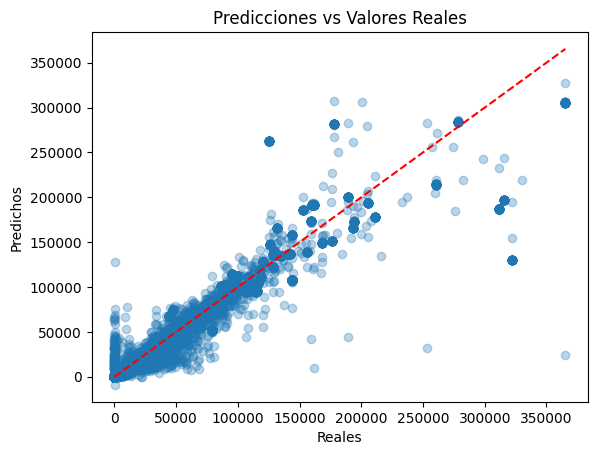

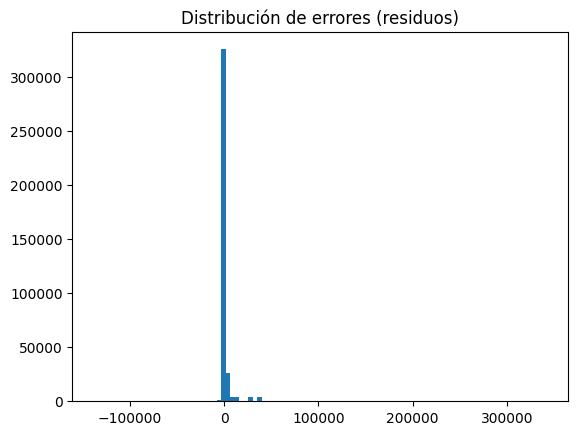

mean absolute percentage error: 4.3519894931237626e+17 %


In [11]:
#VALIDACION 

import matplotlib.pyplot as plt

plt.scatter(y_true_all, y_pred_all, alpha=0.3)
plt.xlabel("Reales")
plt.ylabel("Predichos")
plt.title("Predicciones vs Valores Reales")
plt.plot([y_true_all.min(), y_true_all.max()],
         [y_true_all.min(), y_true_all.max()],
         "r--")  # y=x
plt.show()

residuals = y_true_all - y_pred_all
plt.hist(residuals, bins=100)
plt.title("Distribución de errores (residuos)")
plt.show()

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
print("mean absolute percentage error:", mape*100, "%")


In [12]:
# =========================
# Comparación fila a fila: reales vs predichos
# =========================

eval_df = pd.DataFrame({
    "y_true": y_true_all,
    "y_pred": y_pred_all
})

eval_df["error_abs"] = (eval_df["y_true"] - eval_df["y_pred"]).abs()
eval_df["error_rel_%"] = 100 * eval_df["error_abs"] / eval_df["y_true"].replace(0, np.nan)

# Mostrar las primeras filas
eval_df.head(1000)

eval_df.to_csv("pred_vs_real.csv", index=False)
print("Archivo guardado: pred_vs_real.csv")



Archivo guardado: pred_vs_real.csv


In [13]:
import sys
sys.path.append("../scripts")

from regressor_evaluation import regression_metrics, within_tolerance_accuracy, classification_like_report

# Ejemplo de uso
metrics = regression_metrics(y_true_all, y_pred_all)
print(metrics)

acc_5pct = within_tolerance_accuracy(y_true_all, y_pred_all, tol=0.05)
print("Exactitud ±5%:", acc_5pct)

print(classification_like_report(y_true_all, y_pred_all))


FileNotFoundError: [Errno 2] No such file or directory: 'data_analysis/holdout_manifest.json'

In [ ]:
# =========================
# Función para reentrenar con otro objetivo
# =========================
def train_flow_regressor(
    df_in: pd.DataFrame,
    target_col: str = "packets",
    mode: str = "next_step",
    prefix_len: int = 3,
    n_splits: int = 5,
    random_state: int = 42
) -> Dict:
    # 1) ordenar y typificar
    df2 = df_in.sort_values(FLOW_KEYS + ["ts"]).reset_index(drop=True).copy()
    for c in ["delta_ns","bytes","throughput","loss_est_pkts","dup_acks_est","last_timestamp_ns",target_col]:
        if c in df2.columns:
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
    for c in FLAG_COLS:
        if c in df2.columns:
            df2[c] = df2[c].fillna(0).astype(int)

    # 2) objetivo
    if mode == "next_step":
        wk = build_next_step_target(df2, FLOW_KEYS, target_col)
    elif mode == "final_total":
        wk = build_final_total_target(df2, FLOW_KEYS, target_col, prefix_len)
    else:
        raise ValueError("mode debe ser 'next_step' o 'final_total'.")

    # 3) features
    g = wk.groupby(FLOW_KEYS, sort=False)
    for col in ["packets","bytes","last_timestamp_ns"]:
        if col in wk.columns:
            wk["d_"+col] = g[col].diff().fillna(0)
    if {"d_packets","delta_ns"}.issubset(wk.columns):
        wk["pps"] = safe_rate(wk["d_packets"], wk["delta_ns"]).fillna(0)
    if {"d_bytes","delta_ns"}.issubset(wk.columns):
        wk["bps"] = safe_rate(wk["d_bytes"], wk["delta_ns"]).fillna(0)
    wk = wk.dropna(subset=["y"]).reset_index(drop=True)

    cat_features = [c for c in ["protocol"] if c in wk.columns]
    num_features = [
        c for c in [
            "delta_ns","bytes","throughput","loss_est_pkts","dup_acks_est",
            "d_packets","d_bytes","pps","bps","src_port","dst_port","flow_let",
            ("lag_"+target_col if mode == "next_step" else None)
        ] if c and c in wk.columns
    ]
    bin_features = [c for c in FLAG_COLS if c in wk.columns]

    drop_cols = set([target_col, "y", "rank_in_flow"])
    basic_cols = set(FLOW_KEYS + ["ts"])
    X_cols_local = [c for c in (num_features + bin_features + cat_features)
                    if c not in drop_cols and c not in basic_cols and wk[c].notna().any()]

    numeric_cols = [c for c in X_cols_local if c not in ["protocol"]]
    categorical_cols = [c for c in X_cols_local if c in ["protocol"]]

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
        ],
        remainder="drop"
    )

    model = XGBRegressor(
        n_estimators=300, max_depth=6, learning_rate=0.1, random_state=random_state, n_jobs=-1, tree_method='hist'
    )
    pipe = Pipeline([("pre", pre), ("model", model)])

    y_local = wk["y"].astype("float64").values
    groups = wk.groupby(FLOW_KEYS, sort=False).ngroup().values
    gkf = GroupKFold(n_splits=n_splits)

    fold_metrics, y_true_all, y_pred_all = [], [], []
    for fold, (tr, te) in enumerate(gkf.split(wk[X_cols_local], y_local, groups=groups), 1):
        pipe.fit(wk.iloc[tr][X_cols_local], y_local[tr])
        pred = pipe.predict(wk.iloc[te][X_cols_local])
        mae  = mean_absolute_error(y_local[te], pred)
        rmse = mean_squared_error(y_local[te], pred, squared=False)
        r2   = r2_score(y_local[te], pred)
        fold_metrics.append({"fold": fold, "MAE": mae, "RMSE": rmse, "R2": r2})
        y_true_all.append(y_local[te])
        y_pred_all.append(pred)

    if y_true_all:
        y_true_all = np.concatenate(y_true_all)
        y_pred_all = np.concatenate(y_pred_all)
        mae  = mean_absolute_error(y_true_all, y_pred_all)
        rmse = mean_squared_error(y_true_all, y_pred_all, squared=False)
        r2   = r2_score(y_true_all, y_pred_all)
    else:
        mae = rmse = r2 = np.nan

    # Entrenamiento final
    pipe.fit(wk[X_cols_local], wk["y"])
    artifact = {
        "pipeline": pipe,
        "x_cols": X_cols_local,
        "flow_keys": FLOW_KEYS,
        "target": target_col,
        "mode": mode,
        "prefix_len": prefix_len,
        "cv_metrics": fold_metrics,
        "global_metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
    }
    return artifact


In [ ]:
# =========================
# Ejemplo: entrenar para "bytes"
# =========================
# artifact_bytes = train_flow_regressor(df, target_col="bytes", mode="next_step", prefix_len=3)
# joblib.dump(artifact_bytes, "regressor_flow_bytes.joblib")
# artifact_bytes["global_metrics"]
